In [1]:
%run ../scripts/notebook_settings_lean.py
from scipy import stats
from horizonplot import horizonplot
from chromwindow import window
import zarr
import allel

meta_data_samples_sci = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")

In [2]:
meta_data_samples_sci.loc[meta_data_samples_sci.C_origin == "Anubis, Ethiopia"].Sex.value_counts()

Sex
M    17
F     8
Name: count, dtype: int64

In [3]:
chrX_archaic = pd.read_hdf('../data/runs_papanu4.h5')

In [4]:
chrX_archaic

,chrom,start,end
0,chrX,23837,112924
1,chrX,52970,149722
2,chrX,60386,156179
3,chrX,1995942,2101120
4,chrX,2101120,2212597
...,...,...,...
676,chrX,142987646,143084439
677,chrX,143084440,143183359
678,chrX,143224078,143316657
679,chrX,143473597,143587265


In [5]:
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/"
df_l = []
chroms = ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX", "female_chrX"]
for c in chroms:
    read_file = rfmix_path + "{}.windows.txt".format(c)
    df = pd.read_csv(read_file, sep="\t")
    df_l.append(df)
window_df_eth = pd.concat(df_l)
mean_window_df_eth = window_df_eth.groupby(["chrom", "individual", "start", "end"]).mean().reset_index()

In [6]:
eth_olives = meta_data_samples_sci.loc[meta_data_samples_sci.C_origin == "Anubis, Ethiopia"].PGDP_ID

In [7]:
@window(size=100000)
def archaic_sum(df):
    return (df.end-df.start).sum()

def add_dummy(c_df, window):
    dummy_df = pd.DataFrame()
    dummy_df["end"], dummy_df["start"] = list(range(0, c_df.end.max(), window)), list(range(0, c_df.end.max(), window))
    dummy_df["chrom"] = c_df.chrom.unique()[0]
    return dummy_df

dummy_added = pd.concat([chrX_archaic, add_dummy(chrX_archaic, 100000)]).reset_index().sort_values(by=["start", "end"])
windowed_archaic_df = dummy_added.groupby(['chrom'])[["end", "start"]].apply(archaic_sum).reset_index(drop=True, level=-1).reset_index()
windowed_archaic_df["archaic_sum"] = [min(x, 100000) for x in windowed_archaic_df.archaic_sum]

<Axes: xlabel='start', ylabel='archaic_sum'>

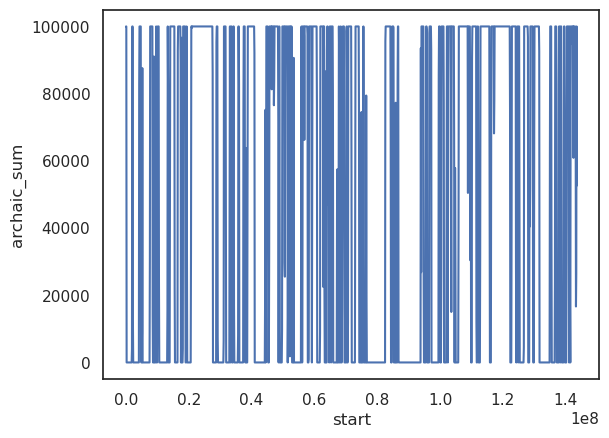

In [8]:
sns.lineplot(data=windowed_archaic_df, x="start", y = "archaic_sum")

In [9]:
chrX_eth = mean_window_df_eth.loc[(mean_window_df_eth.chrom == "all_chrX") &
                                  (mean_window_df_eth.individual.isin(eth_olives))]
chrX_eth["archaic_sum"] = chrX_eth.start.map(dict(zip(windowed_archaic_df.start, windowed_archaic_df.archaic_sum)))

/scratch/29152934/ipykernel_3169036/1736308420.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chrX_eth["archaic_sum"] = chrX_eth.start.map(dict(zip(windowed_archaic_df.start, windowed_archaic_df.archaic_sum)))


In [10]:
hamadryas_ancestry = chrX_eth.groupby(["chrom", "start"])[["archaic_sum", "north_sum"]].mean().reset_index()
hamadryas_ancestry["Hamadryas Ancestry"] = hamadryas_ancestry.north_sum/(hamadryas_ancestry.north_sum.max())

In [11]:
hamadryas_ancestry["ancestry"] = ["olive" if x <= 0.10 else "hamadryas" if x >= 0.9
                        else "mixed" for x in hamadryas_ancestry["Hamadryas Ancestry"]]

<Axes: xlabel='ancestry', ylabel='archaic_sum'>

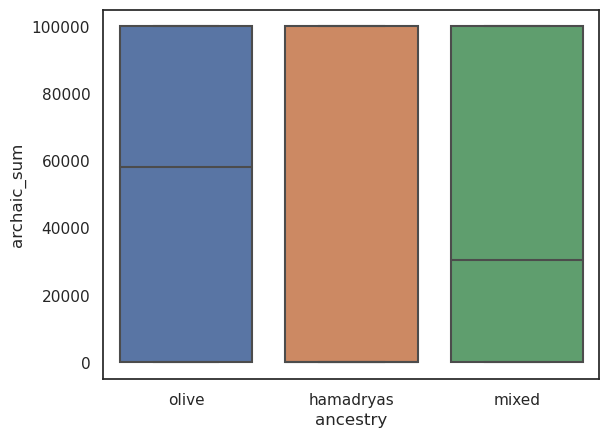

In [12]:
sns.boxplot(data=hamadryas_ancestry, y="archaic_sum", x="ancestry")

<Axes: xlabel='archaic_sum', ylabel='Count'>

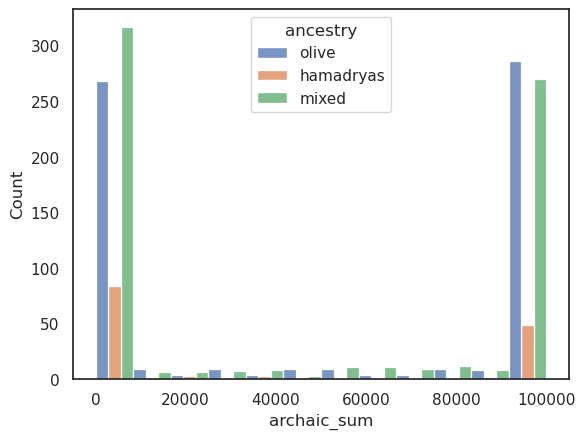

In [13]:
sns.histplot(data=hamadryas_ancestry, x="archaic_sum", hue="ancestry", multiple="dodge")

In [14]:
hamadryas_ancestry.archaic_sum.sum()

68846119.0

In [15]:
hamadryas_ancestry.loc[hamadryas_ancestry.ancestry == "olive"].archaic_sum.sum()

32045911.0

In [16]:
32045911/68846119

0.46547156855711797

In [17]:
hamadryas_ancestry.loc[(hamadryas_ancestry.ancestry == "olive") &
                      (hamadryas_ancestry.archaic_sum == 100000)].archaic_sum.sum()

25200000.0

In [18]:
hamadryas_ancestry.loc[(hamadryas_ancestry.archaic_sum == 100000)].archaic_sum.sum()

52400000.0

In [19]:
len(hamadryas_ancestry.loc[hamadryas_ancestry.ancestry == "olive"])

623

In [20]:
32045911/623000000

0.051438059390048155

In [21]:
623000000/1430000000

0.43566433566433566

<Axes: xlabel='archaic_sum', ylabel='north_sum'>

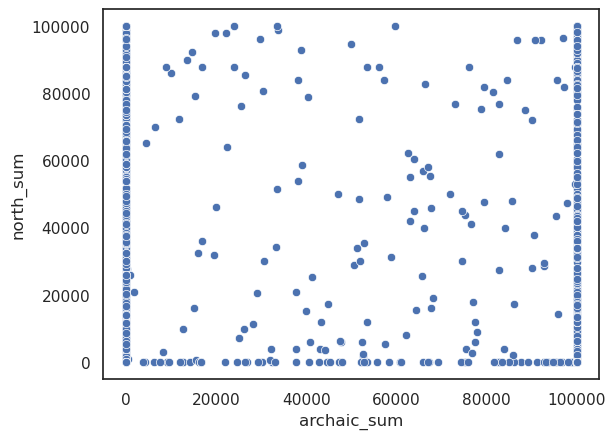

In [22]:
sns.scatterplot(data=hamadryas_ancestry, x="archaic_sum", y="north_sum")

Structural variant section

In [23]:
variant_bed_path = "/home/eriks/XYprimates/people/eriks/sv_papio/v3_pav_analysis/results/Hamadryas/bed/pre_merge/h1/"

In [24]:
ins_df = pd.read_csv(variant_bed_path+"svindel_ins.bed.gz", sep="\t")

In [25]:
ins_df

,#CHROM,POS,END,ID,SVTYPE,SVLEN,HAP,TIG_REGION,QUERY_STRAND,CI,ALIGN_INDEX,CLUSTER_MATCH,LEFT_SHIFT,HOM_REF,HOM_TIG,CALL_SOURCE,SEQ
0,AHZZ02041091.1,13735,13736,AHZZ02041091.1-13736-INS-29,INS,29,h1,Contig357:6590-6618,+,0,9688,NaN,0,"0,1","0,1",CIGAR,GAGTTGGTGAGTCTAGATGTCCAAGTTAA
1,AHZZ02041091.1,13829,13830,AHZZ02041091.1-13830-INS-1,INS,1,h1,Contig357:6713-6713,+,0,9688,NaN,0,"0,10","0,10",CIGAR,t
2,AHZZ02041091.1,21677,21678,AHZZ02041091.1-21678-INS-1,INS,1,h1,Contig357:14554-14554,+,0,9688,NaN,0,"0,0","0,0",CIGAR,G
3,AHZZ02041138.1,6564,6565,AHZZ02041138.1-6565-INS-1,INS,1,h1,Contig591:104072-104072,+,0,12892,NaN,0,"0,0","0,0",CIGAR,a
4,AHZZ02041977.1,1612,1613,AHZZ02041977.1-1613-INS-1,INS,1,h1,Contig743:17661-17661,-,0,14666,NaN,0,"0,0","0,0",CIGAR,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501713,KZ099952.1,37405,37406,KZ099952.1-37406-INS-1,INS,1,h1,Contig1779:2803-2803,-,0,4817,NaN,0,"0,0","0,0",CIGAR,a
1501714,KZ099952.1,37966,37967,KZ099952.1-37967-INS-1,INS,1,h1,Contig1779:2274-2274,-,0,4817,NaN,0,"0,0","0,0",CIGAR,c
1501715,KZ099952.1,38371,38372,KZ099952.1-38372-INS-1,INS,1,h1,Contig1779:1899-1899,-,0,4817,NaN,0,"0,0","0,0",CIGAR,c
1501716,KZ099952.1,38829,38830,KZ099952.1-38830-INS-1,INS,1,h1,Contig1779:1467-1467,-,0,4817,NaN,0,"0,4","0,6",CIGAR,a


In [26]:
chrX_ins = ins_df.loc[(ins_df["#CHROM"] == "CM001511.2") & (ins_df.SVLEN > 50)]
aut_ins = ins_df.loc[(ins_df["#CHROM"] != "CM001511.2") &
                    ins_df["#CHROM"].str.startswith('CM', na=False) & (ins_df.SVLEN > 50)]

In [27]:
aut_ins.SVLEN.mean(), chrX_ins.SVLEN.mean()

(1462.5877406162012, 1362.5747921225384)

<Axes: xlabel='SVLEN', ylabel='Count'>

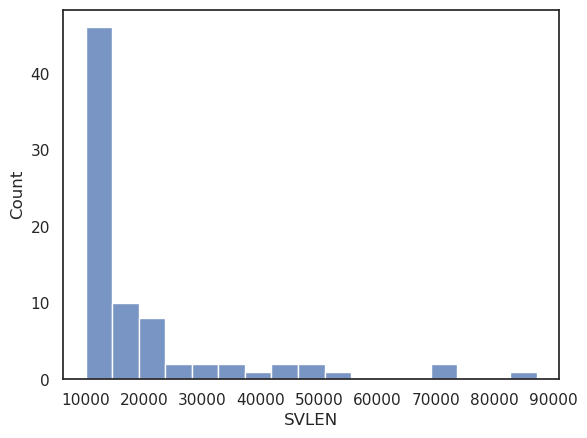

In [28]:
sns.histplot(chrX_ins.loc[chrX_ins.SVLEN > 10000].SVLEN)

<Axes: xlabel='SVLEN', ylabel='Count'>

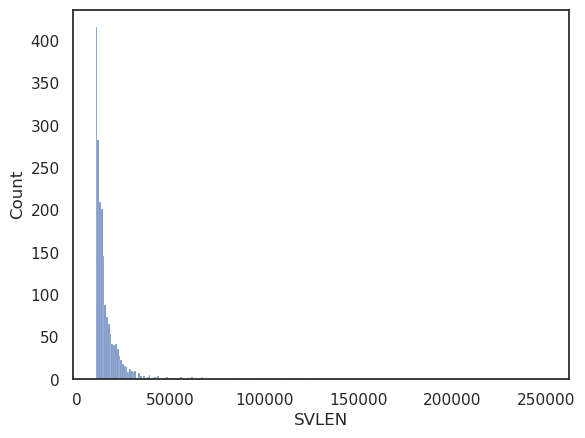

In [29]:
sns.histplot(aut_ins.loc[aut_ins.SVLEN > 10000].SVLEN)

In [30]:
chrX_ins.sort_values(by="SVLEN")

,#CHROM,POS,END,ID,SVTYPE,SVLEN,HAP,TIG_REGION,QUERY_STRAND,CI,ALIGN_INDEX,CLUSTER_MATCH,LEFT_SHIFT,HOM_REF,HOM_TIG,CALL_SOURCE,SEQ
1402511,CM001511.2,57932443,57932444,CM001511.2-57932444-INS-51,INS,51,h1,Contig232:388751-388801,+,0,6765,NaN,0,"0,0","0,0",CIGAR,ACTATATTCAAGTCTCGGATTGTTTGACGACAAACTCAGGCATCAT...
1418100,CM001511.2,77415256,77415257,CM001511.2-77415257-INS-51,INS,51,h1,Contig92:863444-863494,+,0,16289,NaN,0,"0,0","0,0",CIGAR,AGAAATAAATTAAAGGAAATAATTTATTAAGGTGAAACAATATTTA...
1420026,CM001511.2,80450738,80450739,CM001511.2-80450739-INS-51,INS,51,h1,Contig92:4225869-4225919,+,0,16292,NaN,0,"0,1","0,1",CIGAR,taggttgcctgttcactctgatgatagtttcttttgctgtgcagaa...
1454239,CM001511.2,139073467,139073468,CM001511.2-139073468-INS-51,INS,51,h1,Contig165:1062175-1062225,+,0,4312,NaN,0,"0,0","0,0",CIGAR,gagggaTAAAGAGGTCAGATAATGagtatgaaaaggctgggtacag...
1372166,CM001511.2,3192733,3192734,CM001511.2-3192734-INS-51,INS,51,h1,Contig382:218256-218306,+,0,10146,NaN,0,"0,0","0,4",CIGAR,ATATTTAAATATTACATAGTGTACATGCTTATATAGTCCTATAAAA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434074,CM001511.2,105255906,105255907,CM001511.2-105255907-INS-50436,INS,50436,h1,Contig59:330927-381362,+,0,12846,NaN,0,"0,0","0,0",CIGAR,gcagccagagagaaaggtcggttacccacaagggaagcccatcaga...
1452583,CM001511.2,135530402,135530403,CM001511.2-135530403-INS-52925,INS,52925,h1,Contig124:2527619-2580543,-,0,1981,NaN,0,"0,213","0,213",CIGAR,aaaagttaattttgccaagattgaagatgtgcatccatgacacaga...
1381783,CM001511.2,21695973,21695974,CM001511.2-21695974-INS-69476,INS,69476,h1,Contig94:399033-468508,+,0,16424,NaN,0,"0,317","0,498",CIGAR,CCCTGTAGCAGCACAGCAGAGAATAGCACAAGCTGAGAAAAACTCA...
1436180,CM001511.2,108767080,108767081,CM001511.2-108767080-INS-70353,INS,70353,h1,Contig59:4346374-4416726,+,0,"12851,12832",NaN,0,"405,33","405,155",ALNTRUNC,GCAATATAACAAGATTGGAACAAGGCTTCAAAGTGACTCTACTCCA...


In [31]:
@window(size=100000)
def insert_sum(df):
    return (df.SVLEN).sum()
ins_df["start"], ins_df["end"] = ins_df.POS, ins_df.END
window_ins_all = ins_df.loc[ins_df.SVLEN > 50].groupby(['#CHROM'])[["start", "end", "SVLEN"]].apply(insert_sum)

In [32]:
window_ins_all.loc[window_ins_all.insert_sum > 1]

,,start,end,insert_sum
#CHROM,,,,
AHZZ02041977.1,0,0,100000,169
AHZZ02042656.1,0,0,100000,1106
AHZZ02043167.1,0,0,100000,497
AHZZ02043692.1,0,0,100000,1205
AHZZ02044097.1,0,0,100000,503
...,...,...,...,...
KZ099872.1,0,0,100000,678
KZ099882.1,0,0,100000,126
KZ099892.1,0,0,100000,172


In [33]:
window_ins_all.loc[window_ins_all.insert_sum > 1].insert_sum.mean()

9601.070024889483

In [34]:
window_ins_all.reset_index()

,#CHROM,level_1,start,end,insert_sum
0,AHZZ02041977.1,0,0,100000,169
1,AHZZ02042656.1,0,0,100000,1106
2,AHZZ02043167.1,0,0,100000,497
3,AHZZ02043692.1,0,0,100000,1205
4,AHZZ02044097.1,0,0,100000,503
...,...,...,...,...,...
28640,KZ099872.1,0,0,100000,678
28641,KZ099882.1,0,0,100000,126
28642,KZ099892.1,0,0,100000,172
28643,KZ099923.1,0,0,100000,258


In [35]:
aut_ins = window_ins_all.reset_index().loc[(window_ins_all.reset_index()["#CHROM"] == "CM001511.2") &
                                (window_ins_all.reset_index().insert_sum > 1)]
chrX_ins = window_ins_all.reset_index().loc[(window_ins_all.reset_index()["#CHROM"] != "CM001511.2") &
                                        (window_ins_all.reset_index()["#CHROM"].str.startswith('CM', na=False)) & 
                                        (window_ins_all.reset_index().insert_sum > 1)]

In [36]:
chrX_ins.insert_sum.mean(), aut_ins.insert_sum.mean()

(9691.691886326194, 11280.73695652174)

<Axes: xlabel='start', ylabel='insert_sum'>

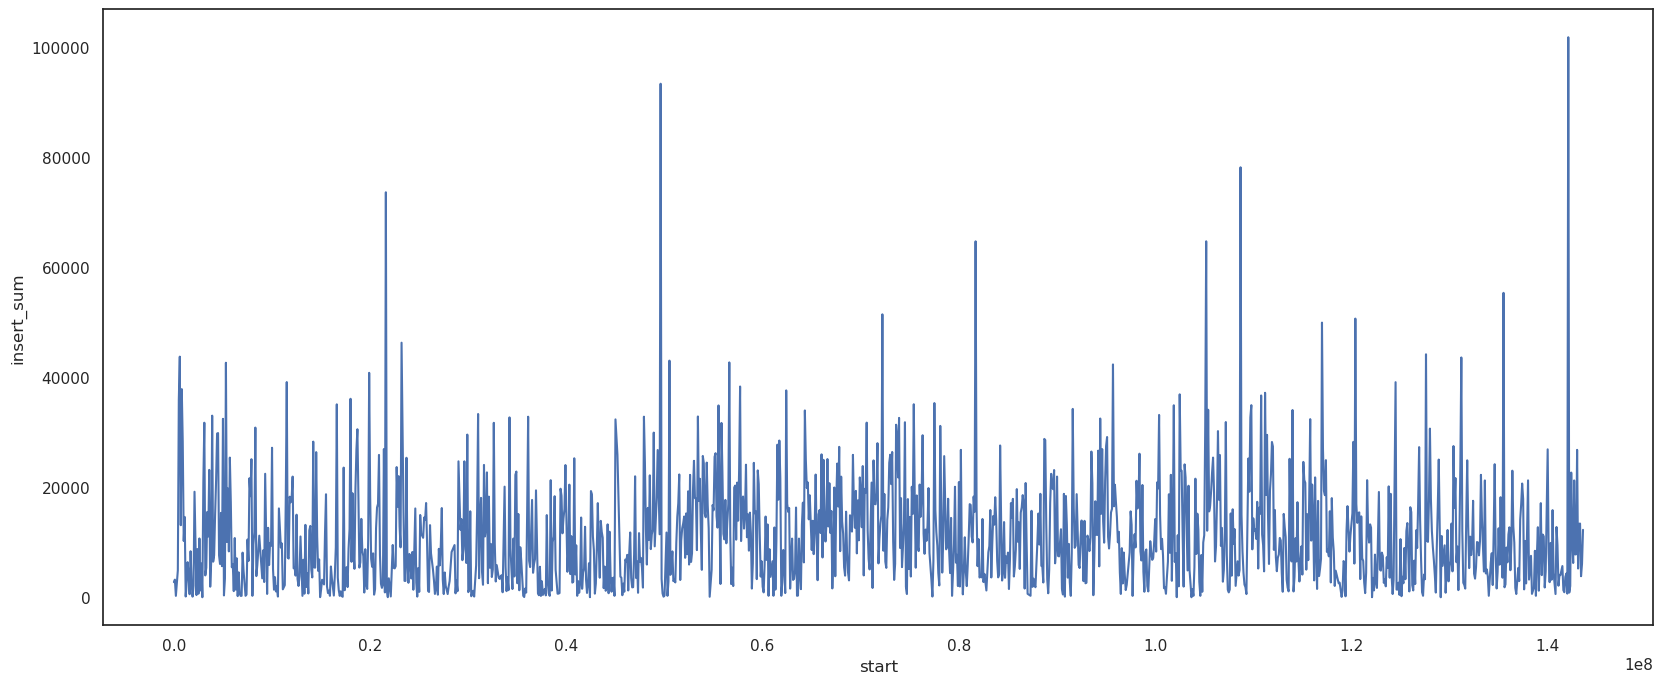

In [37]:
plt.figure(figsize=(20,8))
window_ins_chrX = window_ins_all.reset_index().loc[(window_ins_all.reset_index()["#CHROM"] == "CM001511.2") &
                                (window_ins_all.reset_index().insert_sum > 1)]
sns.lineplot(data=window_ins_chrX, x="start", y="insert_sum")

In [38]:
hamadryas_ancestry["insert_sum"] = hamadryas_ancestry.start.map(dict(zip(window_ins_chrX.start, window_ins_chrX.insert_sum)))

In [39]:
hamadryas_ancestry.loc[hamadryas_ancestry.insert_sum > 1].sort_values(by="insert_sum")

,chrom,start,archaic_sum,north_sum,Hamadryas Ancestry,ancestry,insert_sum
1291,all_chrX,129100000,100000.0,15802.14,0.158021,mixed,53.0
29,all_chrX,2900000,0.0,8000.00,0.080000,olive,55.0
1037,all_chrX,103700000,100000.0,37529.66,0.375297,mixed,56.0
1221,all_chrX,122100000,100000.0,0.00,0.000000,olive,61.0
424,all_chrX,42400000,0.0,84000.00,0.840000,mixed,64.0
...,...,...,...,...,...,...,...
1052,all_chrX,105200000,0.0,32365.84,0.323658,mixed,64753.0
216,all_chrX,21600000,100000.0,0.00,0.000000,olive,73665.0
1087,all_chrX,108700000,99999.0,45738.34,0.457383,mixed,78203.0
496,all_chrX,49600000,0.0,88231.42,0.882314,mixed,93392.0


In [71]:
hamadryas_ancestry["ancestry"] = ["olive" if x <= 0.2 else "hamadryas" if x >= 0.9
                        else "mixed" for x in hamadryas_ancestry["Hamadryas Ancestry"]]

In [72]:
hamadryas_ancestry.loc[hamadryas_ancestry.insert_sum > 1].groupby(by="ancestry")["insert_sum"].mean()

ancestry
hamadryas     9907.478873
mixed        11774.960821
olive        11181.162393
Name: insert_sum, dtype: float64

In [73]:
hamadryas_ancestry.loc[(hamadryas_ancestry.insert_sum > 1) & (hamadryas_ancestry.ancestry == "hamadryas")].insert_sum

25        694.0
26      10740.0
100     27227.0
101      5178.0
102      1426.0
         ...   
1332    22301.0
1333    14339.0
1354     3607.0
1355    55382.0
1356     1865.0
Name: insert_sum, Length: 142, dtype: float64

In [74]:
9650/11173

0.8636892508726394

In [78]:
from scipy import stats
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

statistic(hamadryas_ancestry.loc[(hamadryas_ancestry.ancestry == "hamadryas")].insert_sum, 
          hamadryas_ancestry.loc[(hamadryas_ancestry.ancestry == "olive")].insert_sum, 0)

-1273.6835199229554

In [81]:

ranksums(hamadryas_ancestry.loc[(hamadryas_ancestry.insert_sum.notna()) & (hamadryas_ancestry.ancestry == "hamadryas")].insert_sum, 
          hamadryas_ancestry.loc[(hamadryas_ancestry.insert_sum.notna()) & (hamadryas_ancestry.ancestry == "olive")].insert_sum)

RanksumsResult(statistic=-1.7815234320770263, pvalue=0.07482698040955553)

In [77]:
from scipy.stats import mannwhitneyu
_, pnorm = mannwhitneyu(hamadryas_ancestry.loc[(hamadryas_ancestry.insert_sum > 1) & (hamadryas_ancestry.ancestry == "hamadryas")].insert_sum, 
          hamadryas_ancestry.loc[(hamadryas_ancestry.insert_sum > 1) & (hamadryas_ancestry.ancestry == "olive")].insert_sum, use_continuity=False,
                        method="asymptotic")
print(pnorm)

0.0748269499405757


<Axes: xlabel='insert_sum', ylabel='Count'>

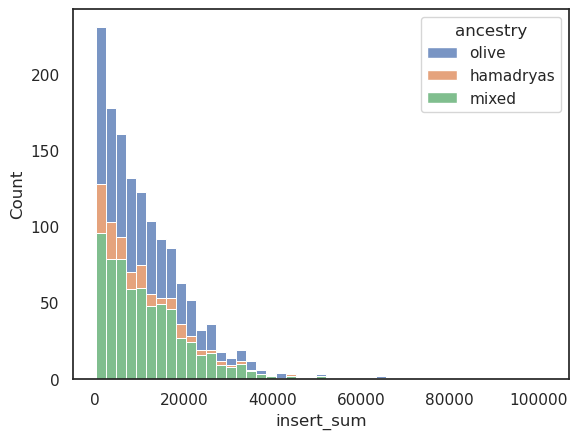

In [48]:
sns.histplot(hamadryas_ancestry, x="insert_sum", hue="ancestry", multiple="stack")

<Axes: xlabel='ancestry', ylabel='insert_sum'>

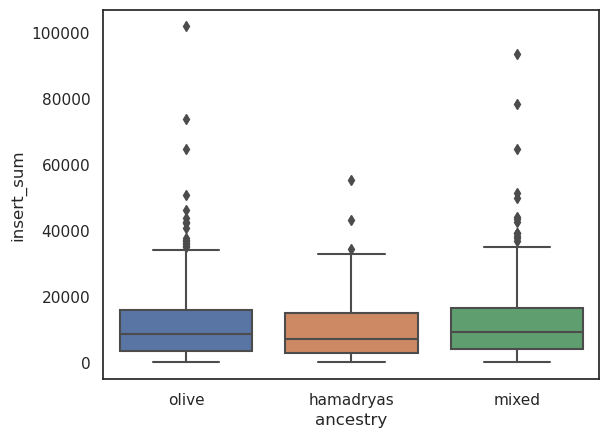

In [40]:
sns.boxplot(data=hamadryas_ancestry.loc[hamadryas_ancestry.insert_sum > 1], y="insert_sum", x="ancestry")

In [41]:
hamadryas_ancestry.loc[hamadryas_ancestry.insert_sum > 1].groupby(by=["ancestry"])["insert_sum"].mean()

ancestry
hamadryas     9907.478873
mixed        11667.406202
olive        11189.001686
Name: insert_sum, dtype: float64

<Axes: xlabel='insert_sum', ylabel='Count'>

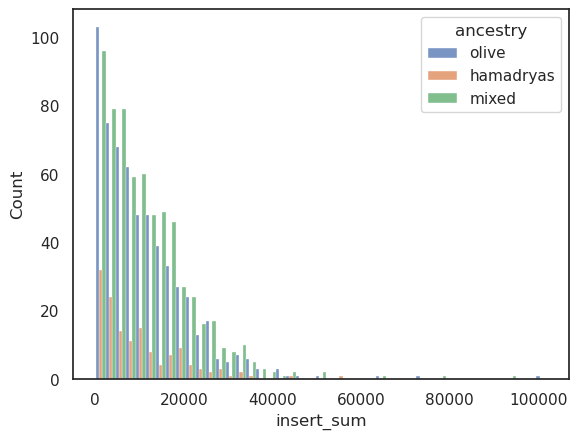

In [42]:
sns.histplot(data=hamadryas_ancestry.loc[hamadryas_ancestry.insert_sum > 1], x="insert_sum", hue="ancestry",
            multiple="dodge")

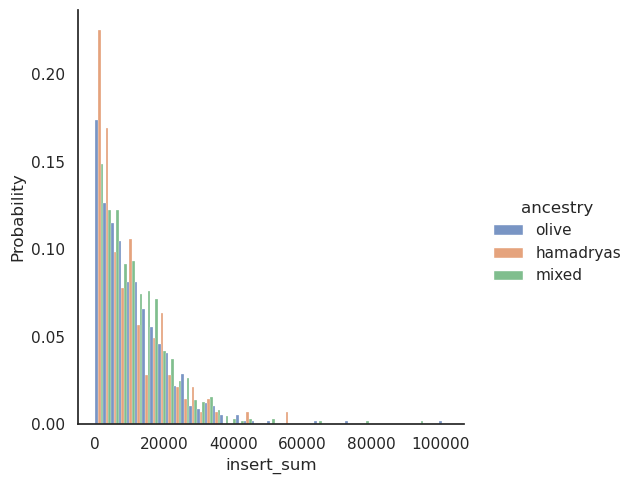

In [43]:
sns.displot(data=hamadryas_ancestry.loc[(hamadryas_ancestry.insert_sum > 1)], x="insert_sum", hue="ancestry",
            multiple="dodge", stat="probability", common_norm=False)

In [44]:
hamadryas_ancestry.loc[hamadryas_ancestry.insert_sum > 1].groupby("ancestry")["insert_sum"].mean()

ancestry
hamadryas     9907.478873
mixed        11667.406202
olive        11189.001686
Name: insert_sum, dtype: float64

In [45]:
ins_df.loc[ins_df.SVLEN > 50]

,#CHROM,POS,END,ID,SVTYPE,SVLEN,HAP,TIG_REGION,QUERY_STRAND,CI,ALIGN_INDEX,CLUSTER_MATCH,LEFT_SHIFT,HOM_REF,HOM_TIG,CALL_SOURCE,SEQ,start,end
6,AHZZ02041977.1,4432,4433,AHZZ02041977.1-4433-INS-169,INS,169,h1,Contig743:14698-14866,-,0,14666,NaN,0,"0,8","0,34",CIGAR,agacagttcttgtggaatctgagaacagatatttcggatccctttg...,4432,4433
33,AHZZ02042656.1,13888,13889,AHZZ02042656.1-13889-INS-1106,INS,1106,h1,Contig1:24579601-24580706,-,0,129,NaN,0,"0,528","0,528",CIGAR,GCGAAGTTGATGAAATTTTGGAGCTCAGAGTAAACGGATCATCAAT...,13888,13889
49,AHZZ02043167.1,6154,6155,AHZZ02043167.1-6155-INS-165,INS,165,h1,Contig867:31252-31416,-,0,15790,NaN,0,"0,3","0,40",CIGAR,gaaagaagctttctgagaaactgctttgtgttctgtgaatcatctc...,6154,6155
59,AHZZ02043167.1,10933,10934,AHZZ02043167.1-10934-INS-165,INS,165,h1,Contig867:26571-26735,-,0,15790,NaN,0,"0,2","0,2",CIGAR,aatatcctcagatgaaatctggaaagaagctttctgagaaactgct...,10933,10934
72,AHZZ02043167.1,12730,12731,AHZZ02043167.1-12731-INS-167,INS,167,h1,Contig867:24647-24813,-,0,15790,NaN,0,"0,0","0,0",CIGAR,gtatttcgtggatctctttgctaagccttatttctgtggaatctga...,12730,12731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501634,KZ099923.1,7597,7598,KZ099923.1-7598-INS-194,INS,194,h1,Contig769:3967-4160,-,0,14861,NaN,0,"0,0","0,0",CIGAR,tatggtgaaaaagtaaatatcctcggatgaaatatggaaagaagct...,7597,7598
1501702,KZ099952.1,28037,28038,KZ099952.1-28038-INS-2044,INS,2044,h1,Contig1779:15607-17650,-,0,4817,NaN,0,"0,0","0,2",CIGAR,tgaagggatatttgggagcgctttgaggcttatgtgaaaaggaaat...,28037,28038
1501710,KZ099952.1,34436,34437,KZ099952.1-34437-INS-1291,INS,1291,h1,Contig1779:8743-10033,-,0,4817,NaN,0,"0,7","0,8",CIGAR,aatctgaaaggacatttggaatgctcttgagaatatgaaaagaaat...,34436,34437
1501711,KZ099952.1,34917,34918,KZ099952.1-34918-INS-2131,INS,2131,h1,Contig1779:6148-8278,-,0,4817,NaN,0,"0,0","0,0",CIGAR,gcagttggaaactcatgtcatggatcatgggacattcgggagcaca...,34917,34918


In [46]:
del_df = pd.read_csv(variant_bed_path+"svindel_del.bed.gz", sep="\t")

/scratch/28232601/ipykernel_1145233/1453529433.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  del_df = pd.read_csv(variant_bed_path+"svindel_del.bed.gz", sep="\t")


In [47]:
chrX_del = del_df.loc[(del_df["#CHROM"] == "CM001511.2") & (del_df.SVLEN > 50)]
aut_del = del_df.loc[(del_df["#CHROM"] != "CM001511.2") &
                    del_df["#CHROM"].str.startswith('CM', na=False) & (del_df.SVLEN > 50)]

In [48]:
chrX_del.SVLEN.mean(), aut_del.SVLEN.mean()

(615.6755863891642, 617.1493509002396)

<Axes: xlabel='SVLEN', ylabel='Count'>

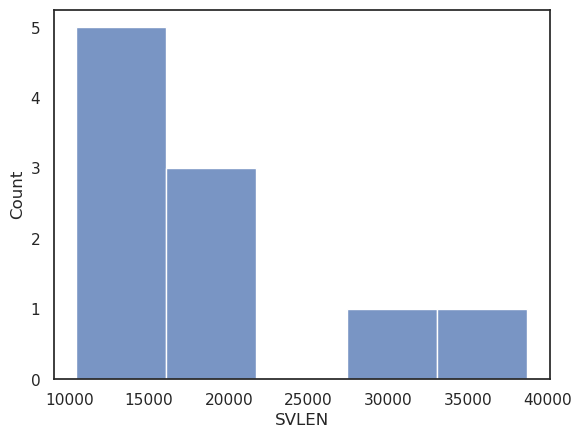

In [49]:
sns.histplot(chrX_del.loc[chrX_del.SVLEN > 10000].SVLEN)

In [50]:
inv_df = pd.read_csv(variant_bed_path+"sv_inv.bed.gz", sep="\t")

In [51]:
chrX_inv = inv_df.loc[(inv_df["#CHROM"] == "CM001511.2")]

In [52]:
chrX_inv

,#CHROM,POS,END,ID,SVTYPE,SVLEN,HAP,TIG_REGION,QUERY_STRAND,CI,RGN_REF_INNER,RGN_TIG_INNER,RGN_REF_DISC,RGN_TIG_DISC,FLAG_ID,FLAG_TYPE,ALIGN_INDEX,CLUSTER_MATCH,CALL_SOURCE,SEQ
43,CM001511.2,11554850,11628866,CM001511.2-11554851-INV-74016,INV,74016,h1,Contig173:932316-1010136,-,0,CM001511.2:11554851-11628866,Contig173:932316-1010136,CM001511.2:11554851-11628866,Contig173:932316-1010136,CM001511.2-11554850-RGN-74016,ALNTRUNC,"4664,4667,4666",NaN,ALNTRUNC-NODEN,aaaaacccaaaataatttcatcaaaaagtgggcaaatgacataaat...
44,CM001511.2,20811474,20840424,CM001511.2-20811475-INV-28950,INV,28950,h1,Contig112:528128-559996,-,0,CM001511.2:20811475-20840424,Contig112:528128-559996,CM001511.2:20811475-20840424,Contig112:528128-559996,CM001511.2-20811474-RGN-28950,ALNTRUNC,"1210,1211,1206",NaN,ALNTRUNC-NODEN,GGAACTATCAGGCAGATTCCCCACGTATAGCTAGGCGAGATTACAT...
45,CM001511.2,30963117,30970066,CM001511.2-30963118-INV-6949,INV,6949,h1,Contig100:2913956-2919969,+,0,CM001511.2:30963118-30970066,Contig100:2913956-2919969,CM001511.2:30947026-30970992,Contig100:2886242-2920907,CM001511.2-30956215-RGN-5587,"{'CLUSTER_SNV', 'MATCH_SV', 'CLUSTER_INDEL'}","(336,)",NaN,FLAG-DEN,ctagccagaacttccaacactatgttgaataggagtggtgagagag...
46,CM001511.2,44011920,44012925,CM001511.2-44011921-INV-1005,INV,1005,h1,Contig98:631210-632042,-,0,CM001511.2:44011921-44012925,Contig98:631210-632042,CM001511.2:44009957-44014911,Contig98:629230-634019,CM001511.2-44011956-RGN-955,ALNTRUNC,"16749,16756",NaN,ALNTRUNC-DEN,tgaggcaggagaatggcttgaactcgggaagcagaggttgtagtga...
47,CM001511.2,45269144,45289925,CM001511.2-45269145-INV-20781,INV,20781,h1,Contig265:655681-681621,+,0,CM001511.2:45269145-45289925,Contig265:655681-673814,CM001511.2:45267145-45291239,Contig265:646827-682932,CM001511.2-45269144-RGN-20095,ALNTRUNC,"7667,7668,7669",NaN,ALNTRUNC-DEN,ggggcagggattggtgagtgctgcacagacagcttcagccgtGACT...
48,CM001511.2,49041878,49161619,CM001511.2-49041879-INV-119741,INV,119741,h1,Contig226:506492-629776,-,0,CM001511.2:49041879-49161619,Contig226:506492-629776,CM001511.2:49041879-49161619,Contig226:506492-629776,CM001511.2-49041878-RGN-119741,ALNTRUNC,"6567,6565,6564",NaN,ALNTRUNC-NODEN,cgattcctcaaggatctagaactagaaataccatttgacttagcca...
49,CM001511.2,104213807,104214354,CM001511.2-104213808-INV-547,INV,547,h1,Contig142:817050-817472,-,0,CM001511.2:104213808-104214354,Contig142:817050-817472,CM001511.2:104211789-104216313,Contig142:815091-821024,CM001511.2-104213788-RGN-525,"{'MATCH_SV', 'CLUSTER_SNV'}","(3075,)",NaN,FLAG-DEN,TGTGTATGGCTGTATGCATATGTACATGGAAATGTTCAAATCAAAA...
50,CM001511.2,135350266,135353032,CM001511.2-135350267-INV-2766,INV,2766,h1,Contig124:2765992-2768736,-,0,CM001511.2:135350267-135352256,Contig124:2766765-2768736,CM001511.2:135332362-135360838,Contig124:2753683-2788687,CM001511.2-135342904-RGN-7391,"{'CLUSTER_INDEL', 'MATCH_SV', 'CLUSTER_SNV'}","(1981,),(1983,)",NaN,FLAG-DEN,tgtaaagaatctttgttaacatagctagatcttttcttccaggccc...


<Axes: xlabel='POS', ylabel='SVLEN'>

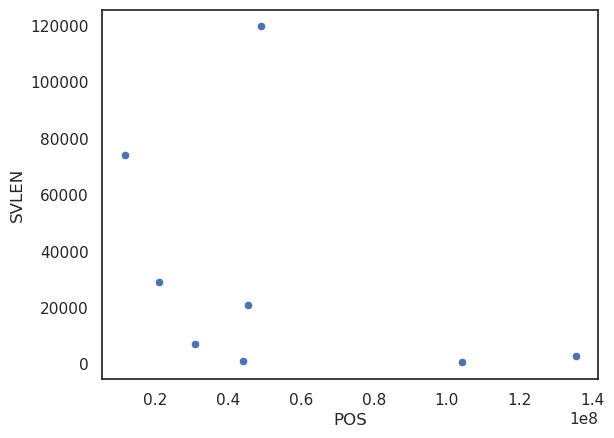

In [53]:
sns.scatterplot(chrX_inv, x="POS", y="SVLEN")

Section to generate a full df containing all sv variant calls and callability.

In [82]:
variant_bed_path = "/home/eriks/XYprimates/people/eriks/sv_papio/v3_pav_analysis/results/Hamadryas/bed/pre_merge/h1/"
ins_df = pd.read_csv(variant_bed_path+"svindel_ins.bed.gz", sep="\t")
del_df = pd.read_csv(variant_bed_path+"svindel_del.bed.gz", sep="\t")
inv_df = pd.read_csv(variant_bed_path+"sv_inv.bed.gz", sep="\t")

/scratch/29152934/ipykernel_3169036/2346615211.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  del_df = pd.read_csv(variant_bed_path+"svindel_del.bed.gz", sep="\t")


In [83]:
ins_df.loc[ins_df.SVLEN > 50].SVLEN.sum(), ins_df.loc[ins_df.SVLEN <= 50].SVLEN.sum()

(258451204, 4028748)

In [84]:
258451204/(258451204+4028748)

0.9846512163336574

In [85]:
del_df.loc[del_df.SVLEN > 50].SVLEN.sum(), del_df.loc[del_df.SVLEN <= 50].SVLEN.sum()

(35327546, 6084917)

In [86]:
35327546/(35327546+6084917)

0.8530655614470456

In [87]:
call_df = pd.read_csv("/home/eriks/XYprimates/people/eriks/sv_papio/v3_pav_analysis/results/Hamadryas/callable/callable_regions_h1_500.bed.gz",
                     sep="\t")

In [88]:
call_df

,#CHROM,POS,END
0,AHZZ02041091.1,7144,25803
1,AHZZ02041138.1,1335,12769
2,AHZZ02041977.1,0,11145
3,AHZZ02042051.1,0,11880
4,AHZZ02042656.1,1587,25942
...,...,...,...
3900,KZ099923.1,1,11565
3901,KZ099924.1,23,15907
3902,KZ099945.1,2875,15597
3903,KZ099952.1,1772,19161


In [89]:
chr_list = call_df.loc[call_df["#CHROM"].str.startswith('CM', na=False)]["#CHROM"].unique()

In [90]:
@window(size=100000)
def insert_sum(df):
    return (df.SVLEN).sum()
ins_df["start"], ins_df["end"] = ins_df.POS, ins_df.END
window_ins_all = ins_df.loc[ins_df.SVLEN > 50].groupby(['#CHROM'])[["start", "end", "SVLEN"]].apply(insert_sum).reset_index()
@window(size=100000)
def del_sum(df):
    return (df.SVLEN).sum()
del_df["start"], del_df["end"] = del_df.POS, del_df.END
window_del_all = del_df.loc[del_df.SVLEN > 50].groupby(['#CHROM'])[["start", "end", "SVLEN"]].apply(del_sum).reset_index()
@window(size=100000)
def call_sum(df):
    return (df.end-df.start).sum()
call_df["start"], call_df["end"] = call_df.POS, call_df.END
window_call_all = call_df.groupby(['#CHROM'])[["start", "end"]].apply(call_sum).reset_index()

In [91]:
window_ins_all

,#CHROM,level_1,start,end,insert_sum
0,AHZZ02041977.1,0,0,100000,169
1,AHZZ02042656.1,0,0,100000,1106
2,AHZZ02043167.1,0,0,100000,497
3,AHZZ02043692.1,0,0,100000,1205
4,AHZZ02044097.1,0,0,100000,503
...,...,...,...,...,...
28640,KZ099872.1,0,0,100000,678
28641,KZ099882.1,0,0,100000,126
28642,KZ099892.1,0,0,100000,172
28643,KZ099923.1,0,0,100000,258


In [92]:
window_del_all

,#CHROM,level_1,start,end,del_sum
0,AHZZ02042051.1,0,0,100000,501
1,AHZZ02043167.1,0,0,100000,171
2,AHZZ02044097.1,0,0,100000,305
3,AHZZ02045594.1,0,0,100000,278
4,AHZZ02045742.1,0,0,100000,344
...,...,...,...,...,...
28496,KZ099904.1,0,0,100000,51
28497,KZ099915.1,0,0,100000,1284
28498,KZ099917.1,0,0,100000,365
28499,KZ099924.1,0,0,100000,868


In [93]:
ins_del = window_ins_all.merge(window_del_all, on=["#CHROM", "start", "end"])
ins_del_call = ins_del.merge(window_call_all, on=["#CHROM", "start", "end"])

In [94]:
ins_del_call_chroms = ins_del_call.loc[ins_del_call["#CHROM"].isin(chr_list)]
ins_del_call_chroms["callability"] = ins_del_call_chroms.call_sum/100000
ins_del_call_chroms["ins+del"] = ins_del_call_chroms.insert_sum+ins_del_call_chroms.del_sum
ins_del_call_chroms["ins-del"] = ins_del_call_chroms.insert_sum-ins_del_call_chroms.del_sum

/scratch/29152934/ipykernel_3169036/4274478493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ins_del_call_chroms["callability"] = ins_del_call_chroms.call_sum/100000
/scratch/29152934/ipykernel_3169036/4274478493.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ins_del_call_chroms["ins+del"] = ins_del_call_chroms.insert_sum+ins_del_call_chroms.del_sum
/scratch/29152934/ipykernel_3169036/4274478493.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

<Axes: xlabel='start', ylabel='insert_sum'>

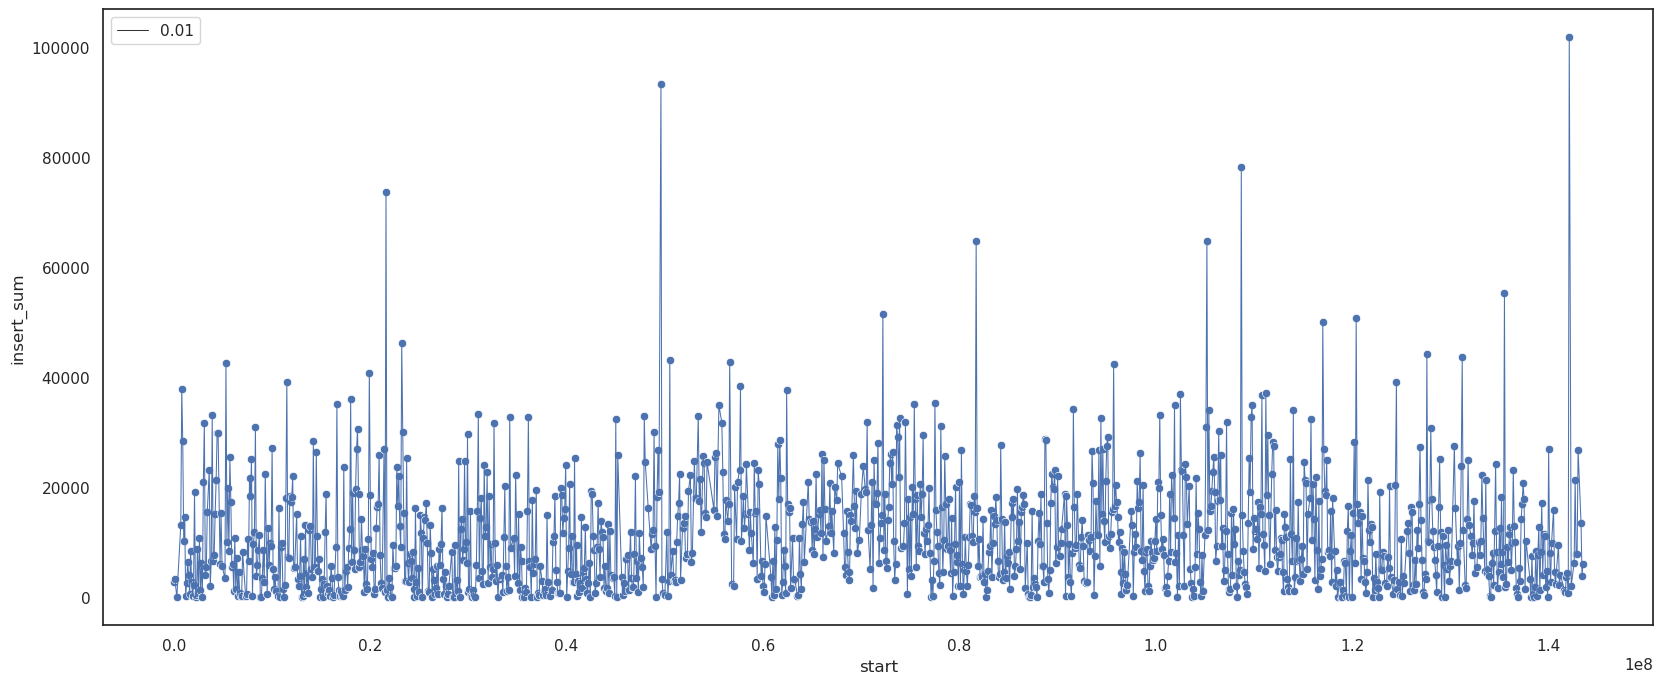

In [95]:
plt.figure(figsize=(20,8))
window_ins_chrX = ins_del_call_chroms.reset_index().loc[(ins_del_call_chroms.reset_index()["#CHROM"] == "CM001511.2") &
                                (ins_del_call_chroms.reset_index().callability > 0.9)]
sns.lineplot(data=window_ins_chrX, x="start", y="insert_sum", size=0.01)
sns.scatterplot(data=window_ins_chrX, x="start", y="insert_sum")

<Axes: xlabel='start', ylabel='ins+del'>

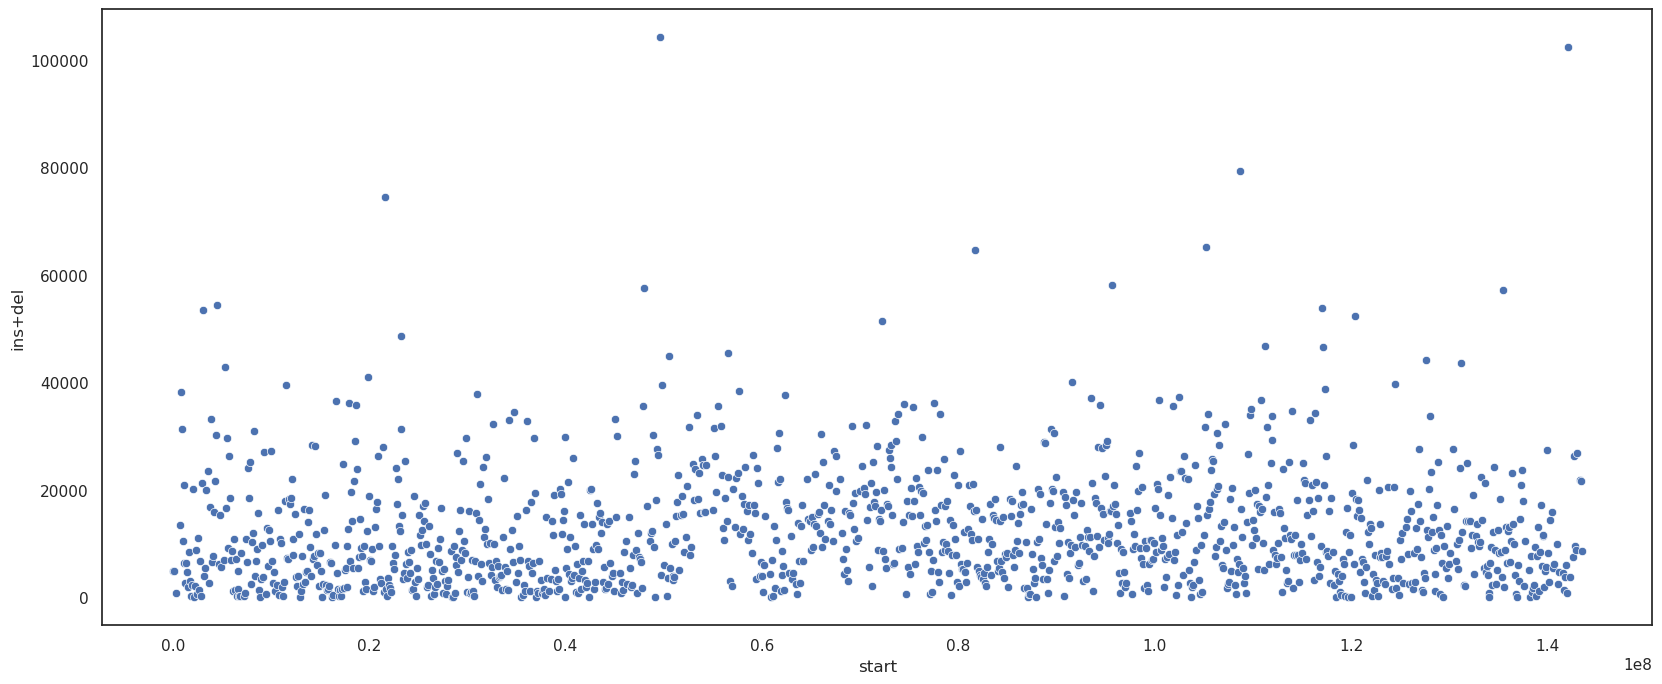

In [96]:
plt.figure(figsize=(20,8))

sns.scatterplot(data=window_ins_chrX, x="start", y="ins+del")

In [97]:
eth_olives = meta_data_samples_sci.loc[meta_data_samples_sci.C_origin == "Anubis, Ethiopia"].PGDP_ID
grouped_means = mean_window_df_eth.loc[mean_window_df_eth.individual.isin(eth_olives)].groupby(["chrom", "start", "end"])["north_sum"].mean().reset_index()
grouped_means["ancestry"] = ["olive" if x <= 10000 else "hamadryas" if x >= 90000
                        else "mixed" for x in grouped_means["north_sum"]]

In [98]:
CM_chr_map = dict(zip(chr_list, ["chr{}".format(x) for x in range(1,21)]+["all_chrX"]))
ins_del_call_chroms["chrom"] = ins_del_call_chroms["#CHROM"].map(CM_chr_map)

/scratch/29152934/ipykernel_3169036/845429500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ins_del_call_chroms["chrom"] = ins_del_call_chroms["#CHROM"].map(CM_chr_map)


In [99]:
ancestry_sv = ins_del_call_chroms.merge(grouped_means, on=["chrom", "start", "end"])

<Axes: xlabel='ins+del', ylabel='Probability'>

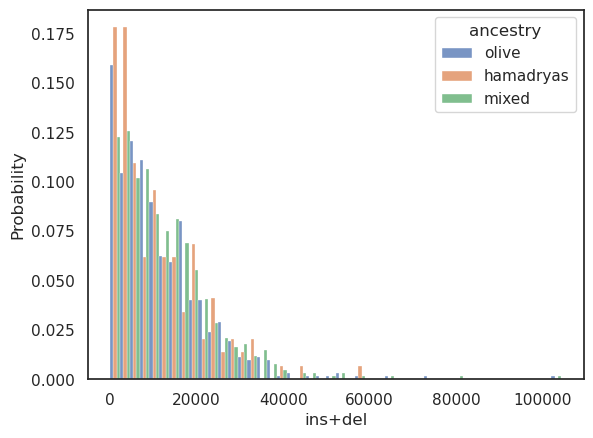

In [100]:
sns.histplot(ancestry_sv.loc[ancestry_sv.chrom == "all_chrX"], x="ins+del", hue="ancestry", multiple="dodge",
            common_norm=False, stat="probability")

<Axes: xlabel='ins+del', ylabel='Probability'>

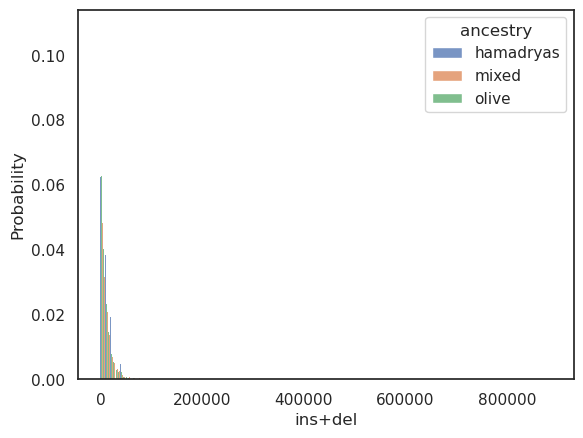

In [101]:
sns.histplot(ancestry_sv, x="ins+del", hue="ancestry", multiple="dodge",
            common_norm=False, stat="probability")

<Axes: xlabel='start', ylabel='insert_sum'>

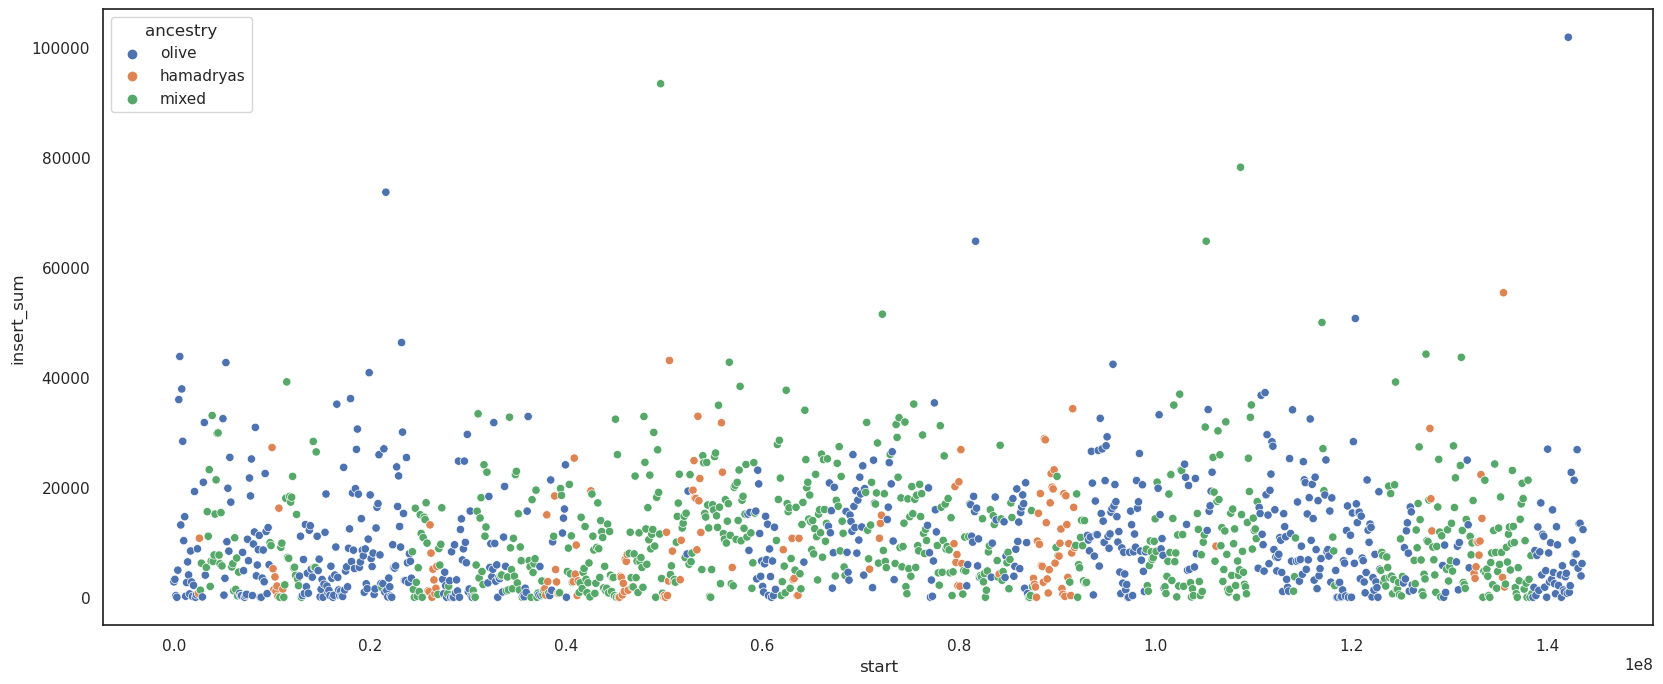

In [102]:
plt.figure(figsize=(20,8))

sns.scatterplot(data=ancestry_sv.loc[ancestry_sv.chrom == "all_chrX"], x="start", y="insert_sum", hue="ancestry")

<Axes: xlabel='start', ylabel='del_sum'>

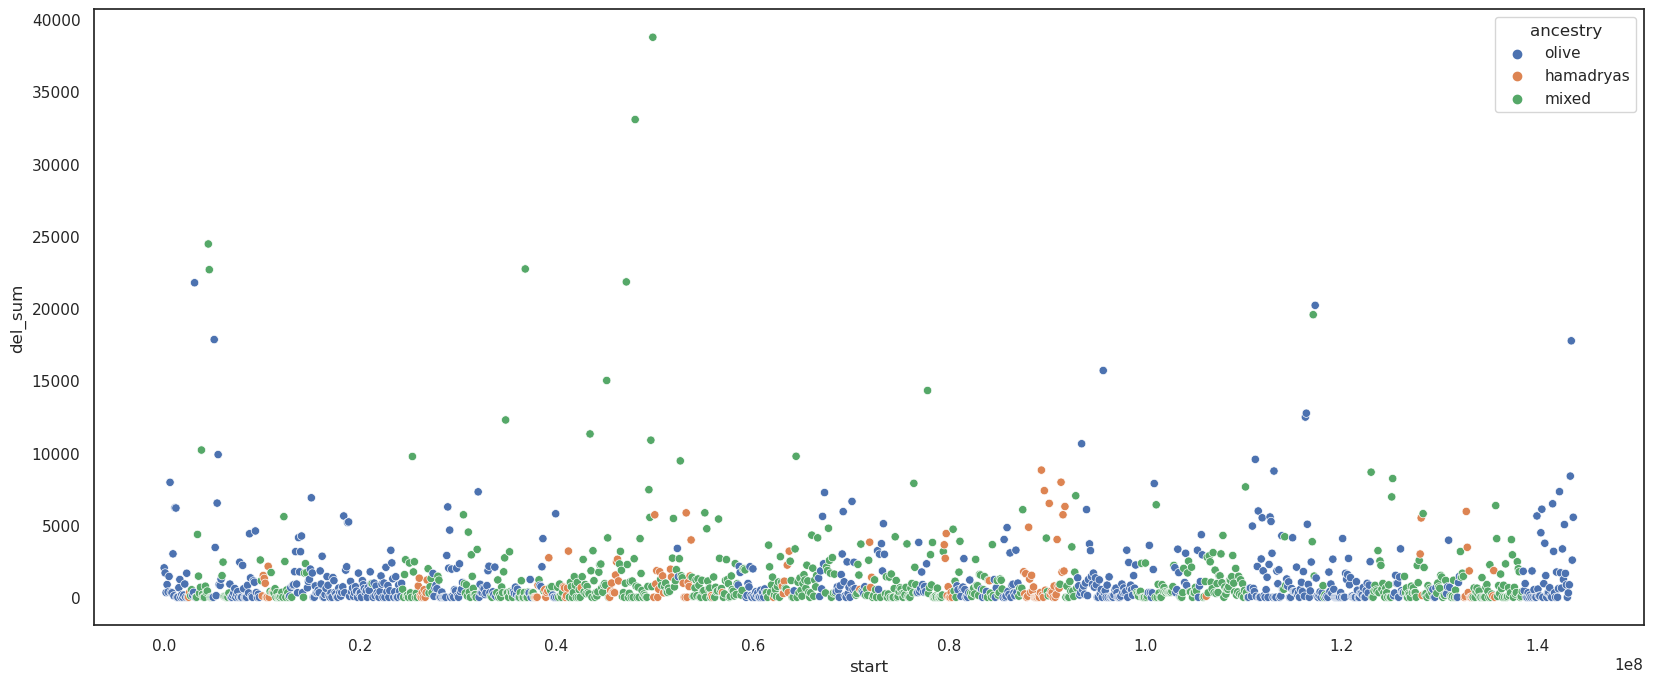

In [103]:
plt.figure(figsize=(20,8))

sns.scatterplot(data=ancestry_sv.loc[ancestry_sv.chrom == "all_chrX"], x="start", y="del_sum", hue="ancestry")

In [104]:
ancestry_sv.loc[ancestry_sv.chrom.isin(["chr{}".format(x) for x in range(1,21)])].groupby(["ancestry"])[["insert_sum", "del_sum"]].mean()

,insert_sum,del_sum
ancestry,,
hamadryas,13323.629032,1469.161290
mixed,10088.948574,1410.872421
olive,8710.482644,1579.592279


In [105]:
ancestry_sv.loc[ancestry_sv.chrom.isin((["chr{}".format(x) for x in range(1,21)])) &
               (ancestry_sv.callability > 0.9)].groupby(["ancestry"])[["insert_sum", "del_sum"]].mean()

,insert_sum,del_sum
ancestry,,
hamadryas,13077.627451,1325.019608
mixed,10106.030733,1398.674862
olive,8727.820603,1584.259668


In [106]:
ancestry_sv.loc[ancestry_sv.chrom.isin((["chr{}".format(x) for x in range(1,21)])) &
               (ancestry_sv.callability < 0.9)]#.groupby(["ancestry"])[["insert_sum", "del_sum"]].mean()

,#CHROM,level_1_x,start,end,insert_sum,level_1_y,del_sum,level_1,call_sum,callability,ins+del,ins-del,chrom,north_sum,ancestry
0,CM001491.2,0,0,100000,4722,0,1035,0,60448,0.60448,5757,3687,chr1,98574.48,hamadryas
4,CM001491.2,4,400000,500000,30276,4,4858,4,83851,0.83851,35134,25418,chr1,85936.82,mixed
88,CM001491.2,88,8800000,8900000,14484,88,989,88,79634,0.79634,15473,13495,chr1,0.00,olive
117,CM001491.2,117,11700000,11800000,0,117,0,117,0,0.00000,0,0,chr1,4134.40,olive
118,CM001491.2,118,11800000,11900000,30998,118,3025,118,85517,0.85517,34023,27973,chr1,0.00,olive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25590,CM001510.2,383,38300000,38400000,10481,383,225,383,27346,0.27346,10706,10256,chr20,921.64,olive
25591,CM001510.2,384,38400000,38500000,0,384,156,384,10261,0.10261,156,-156,chr20,235.28,olive
25592,CM001510.2,385,38500000,38600000,15273,385,442,385,80826,0.80826,15715,14831,chr20,0.00,olive
25917,CM001510.2,710,71000000,71100000,22316,710,4404,710,89268,0.89268,26720,17912,chr20,33323.12,mixed


In [107]:
ancestry_sv.loc[(ancestry_sv.chrom.isin(["chr{}".format(x) for x in range(1,21)])) &
               (ancestry_sv.ancestry == "hamadryas")]

,#CHROM,level_1_x,start,end,insert_sum,level_1_y,del_sum,level_1,call_sum,callability,ins+del,ins-del,chrom,north_sum,ancestry
0,CM001491.2,0,0,100000,4722,0,1035,0,60448,0.60448,5757,3687,chr1,98574.48,hamadryas
1,CM001491.2,1,100000,200000,2092,1,1141,1,96188,0.96188,3233,951,chr1,98000.00,hamadryas
2,CM001491.2,2,200000,300000,2426,2,452,2,100000,1.00000,2878,1974,chr1,98929.40,hamadryas
3,CM001491.2,3,300000,400000,0,3,3672,3,100000,1.00000,3672,-3672,chr1,100000.00,hamadryas
99,CM001491.2,99,9900000,10000000,10309,99,807,99,100000,1.00000,11116,9502,chr1,90000.00,hamadryas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25776,CM001510.2,569,56900000,57000000,34956,569,1226,569,97107,0.97107,36182,33730,chr20,94000.00,hamadryas
25777,CM001510.2,570,57000000,57100000,8033,570,3005,570,100000,1.00000,11038,5028,chr20,95406.66,hamadryas
25778,CM001510.2,571,57100000,57200000,1561,571,3243,571,100000,1.00000,4804,-1682,chr20,95999.98,hamadryas
25779,CM001510.2,572,57200000,57300000,6288,572,326,572,100000,1.00000,6614,5962,chr20,96000.00,hamadryas


<Axes: xlabel='insert_sum', ylabel='Count'>

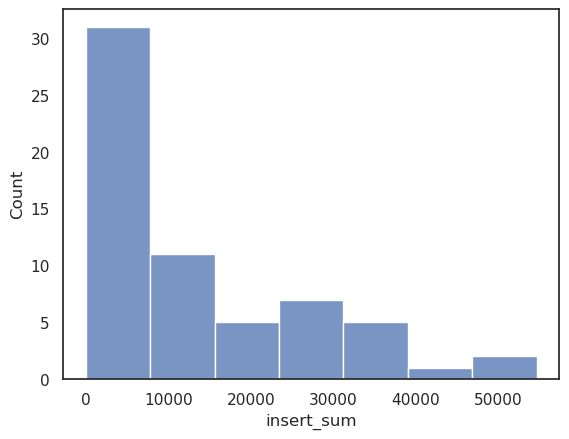

In [108]:
sns.histplot(ancestry_sv.loc[(ancestry_sv.chrom.isin(["chr{}".format(x) for x in range(1,21)])) &
               (ancestry_sv.ancestry == "hamadryas")].insert_sum)

In [109]:
ancestry_sv.loc[(ancestry_sv.chrom.isin(["all_chrX"])) &
               (ancestry_sv.ancestry == "mixed") & (ancestry_sv.callability > 0.9)]

,#CHROM,level_1_x,start,end,insert_sum,level_1_y,del_sum,level_1,call_sum,callability,ins+del,ins-del,chrom,north_sum,ancestry
25954,CM001511.2,27,2700000,2800000,1285,27,103,27,100000,1.00000,1388,1182,all_chrX,67927.98,mixed
25955,CM001511.2,28,2800000,2900000,6190,28,522,28,100000,1.00000,6712,5668,all_chrX,14000.52,mixed
25960,CM001511.2,33,3300000,3400000,5425,33,0,33,100000,1.00000,5425,5425,all_chrX,12177.20,mixed
25961,CM001511.2,34,3400000,3500000,15561,34,4349,34,100000,1.00000,19910,11212,all_chrX,16400.06,mixed
25963,CM001511.2,36,3600000,3700000,23202,36,273,36,91396,0.91396,23475,22929,all_chrX,26000.00,mixed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27304,CM001511.2,1377,137700000,137800000,10290,1377,214,1377,97906,0.97906,10504,10076,all_chrX,54000.00,mixed
27308,CM001511.2,1381,138100000,138200000,3264,1381,1765,1381,100000,1.00000,5029,1499,all_chrX,34000.00,mixed
27309,CM001511.2,1382,138200000,138300000,0,1382,0,1382,100000,1.00000,0,0,all_chrX,32378.76,mixed
27310,CM001511.2,1383,138300000,138400000,7581,1383,62,1383,100000,1.00000,7643,7519,all_chrX,30000.00,mixed


In [110]:
ancestry_sv.loc[(ancestry_sv.chrom.isin(["all_chrX"]))  &
               (ancestry_sv.del_sum > 10000)]

,#CHROM,level_1_x,start,end,insert_sum,level_1_y,del_sum,level_1,call_sum,callability,ins+del,ins-del,chrom,north_sum,ancestry
25958,CM001511.2,31,3100000,3200000,31775,31,21774,31,91551,0.91551,53549,10001,all_chrX,6011.12,olive
25965,CM001511.2,38,3800000,3900000,6572,38,10192,38,100000,1.00000,16764,-3620,all_chrX,40279.46,mixed
25972,CM001511.2,45,4500000,4600000,29893,45,24459,45,95794,0.95794,54352,5434,all_chrX,54353.30,mixed
25973,CM001511.2,46,4600000,4700000,7674,46,22679,46,65494,0.65494,30353,-15005,all_chrX,46760.00,mixed
25978,CM001511.2,51,5100000,5200000,384,51,17841,51,81323,0.81323,18225,-17457,all_chrX,0.00,olive
26275,CM001511.2,348,34800000,34900000,22305,348,12274,348,100000,1.00000,34579,10031,all_chrX,42949.76,mixed
26295,CM001511.2,368,36800000,36900000,6997,368,22730,368,100000,1.00000,29727,-15733,all_chrX,37584.70,mixed
26361,CM001511.2,434,43400000,43500000,3602,434,11306,434,100000,1.00000,14908,-7704,all_chrX,27874.88,mixed
26378,CM001511.2,451,45100000,45200000,0,451,15008,451,100000,1.00000,15008,-15008,all_chrX,34216.80,mixed
26398,CM001511.2,471,47100000,47200000,3558,471,21833,471,100000,1.00000,25391,-18275,all_chrX,41252.42,mixed


In [111]:
ancestry_sv.loc[(ancestry_sv.chrom.isin(["all_chrX"]))  &
               (ancestry_sv.insert_sum > 50000)]

,#CHROM,level_1_x,start,end,insert_sum,level_1_y,del_sum,level_1,call_sum,callability,ins+del,ins-del,chrom,north_sum,ancestry
26143,CM001511.2,216,21600000,21700000,73665,216,772,216,100000,1.0,74437,72893,all_chrX,0.00,olive
26423,CM001511.2,496,49600000,49700000,93392,496,10875,496,100000,1.0,104267,82517,all_chrX,88231.42,mixed
26649,CM001511.2,722,72200000,72300000,51478,722,0,722,100000,1.0,51478,51478,all_chrX,80738.18,mixed
26744,CM001511.2,817,81700000,81800000,64746,817,0,817,100000,1.0,64746,64746,all_chrX,0.00,olive
26979,CM001511.2,1052,105200000,105300000,64753,1052,449,1052,100000,1.0,65202,64304,all_chrX,32365.84,mixed
27014,CM001511.2,1087,108700000,108800000,78203,1087,1152,1087,100000,1.0,79355,77051,all_chrX,45738.34,mixed
27131,CM001511.2,1204,120400000,120500000,50701,1204,1658,1204,100000,1.0,52359,49043,all_chrX,0.00,olive
27282,CM001511.2,1355,135500000,135600000,55382,1355,1845,1355,100000,1.0,57227,53537,all_chrX,93018.74,hamadryas
27348,CM001511.2,1421,142100000,142200000,101843,1421,597,1421,100000,1.0,102440,101246,all_chrX,0.00,olive


In [118]:
ancestry_sv.loc[ancestry_sv.chrom.isin(["all_chrX"]) & (ancestry_sv.callability > 0.5)
               ].groupby(["ancestry"])[["insert_sum", "del_sum"]].mean()

,insert_sum,del_sum
ancestry,,
hamadryas,9743.472222,1243.451389
mixed,11389.074468,1411.241641
olive,10675.711290,1331.640323


In [113]:
ancestry_sv.loc[ancestry_sv.chrom.isin(["all_chrX"]) & (ancestry_sv.callability > 0.9)].groupby(["ancestry"])[["insert_sum", "del_sum"]].var()

,insert_sum,del_sum
ancestry,,
hamadryas,9.711962e+07,3.480485e+06
mixed,1.102270e+08,1.046815e+07
olive,1.091735e+08,5.299152e+06


In [114]:
ancestry_sv.loc[ancestry_sv.chrom.isin(["all_chrX"]) & (ancestry_sv.callability > 0.9)
               ][["insert_sum", "del_sum"]].mean()

insert_sum    11010.041507
del_sum        1324.003843
dtype: float64

In [115]:
ancestry_sv.loc[ancestry_sv.chrom.isin(["chr{}".format(x) for x in range(1,21)]) & (ancestry_sv.callability > 0.9)
               ][["insert_sum", "del_sum"]].mean()

insert_sum    9084.061502
del_sum       1536.951093
dtype: float64

In [116]:
ancestry_sv.loc[ancestry_sv.chrom.isin(["chr{}".format(x) for x in range(1,21)]) & (ancestry_sv.callability > 0.9)].groupby(["ancestry"])[["insert_sum", "del_sum"]].var()

,insert_sum,del_sum
ancestry,,
hamadryas,1.629831e+08,2.452523e+06
mixed,1.687386e+08,1.125122e+08
olive,1.244807e+08,3.026396e+08
